# Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

**Задание 1 : Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.**

In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.metrics import roc_auc_score, roc_curve

In [64]:
import time

In [69]:
from sklearn.preprocessing import LabelEncoder

In [2]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    data = pd.read_csv(csv_path)
    data.columns=[col.upper() for col in data.columns]
    print("shape = {} rows, {} cols".format(*data.shape))
    return data

In [4]:
train = load_data("train.csv")
test = load_data("test.csv")
client_profile=load_data("client_profile.csv")

shape = 110093 rows, 3 cols
shape = 165141 rows, 2 cols
shape = 250000 rows, 24 cols


In [5]:
def target_description_print(ds, target_name):                              
    """
    Печать распределения целевых значений.
    
    Parameters
    ----------
    ds: pd.DataFrame
        Вектор целевой переменной.
    target_name: str
        название целевого поля
    """
    
    values_count_TARGET_0 = ds[ds[target_name]==0].count()[target_name]
    values_count_TARGET_1 = ds[ds[target_name]==1].count()[target_name]
    values_count_TARGET_1_2 = np.around(values_count_TARGET_1/values_count_TARGET_0,3)
    values_count_TARGET_Sum = values_count_TARGET_0+values_count_TARGET_1
    print("TARGET==0 values count =",values_count_TARGET_0)
    print("TARGET==1 values count =",values_count_TARGET_1)
    print("(TARGET==1)count / (TARGET==0)count =",values_count_TARGET_1_2)
    print("TARGET==0 and TARGET==1 in sum values count =",values_count_TARGET_Sum)

In [6]:
target_description_print(train,'TARGET')

TARGET==0 values count = 101196
TARGET==1 values count = 8897
(TARGET==1)count / (TARGET==0)count = 0.088
TARGET==0 and TARGET==1 in sum values count = 110093


In [7]:
numerical_features = client_profile.select_dtypes(exclude=["object"])
numerical_features=numerical_features.drop(["APPLICATION_NUMBER"],axis=1)

In [11]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [9]:
from sklearn.impute import KNNImputer

In [10]:
knn_imputer = KNNImputer(n_neighbors=25, weights="uniform")
client_profile["AMOUNT_ANNUITY"] = knn_imputer.fit_transform(client_profile[["AMOUNT_ANNUITY"]])
client_profile["FAMILY_SIZE"] = knn_imputer.fit_transform(client_profile[["FAMILY_SIZE"]])
client_profile["EXTERNAL_SCORING_RATING_2"] = knn_imputer.fit_transform(client_profile[["EXTERNAL_SCORING_RATING_2"]])

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [14]:
iterative_imputer = IterativeImputer()
client_profile[numerical_features.columns] = iterative_imputer.fit_transform(client_profile[numerical_features.columns])


In [15]:
client_profile_missing = check_missings(client_profile)
client_profile_missing

Total NA-values = 0


""
Total
Percent
Types


In [87]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          cat_feats,
                          metric: callable,                          
                          cv_strategy,                          
                          isCatBoost=False
                          ):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        if isCatBoost:
            estimator.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)],
                          cat_features=cat_feats,plot=True)
        else:
            estimator.fit(X=x_train,y=y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                      early_stopping_rounds=500,
                      eval_metric="auc",
                      verbose=200,
                      categorical_feature=cat_feats)
        
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        
        oof_predictions[valid_idx] = y_valid_pred
        oof_predictions[train_idx] = y_train_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)        

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores,fold_valid_scores, oof_predictions

In [113]:
def xgboost_cross_validation(params, X, y, cv, metric: callable,  categorical = None):
    """
    Кросс-валидация для модели xgbbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}    
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=1000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=200,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        oof_preds[train_idx] = model.predict(dtrain)
        
        
        estimators.append(model)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        
    oof_score = metric(y, oof_preds)
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, oof_preds

In [152]:
def random_forest_cross_validation( X, y, cv, metric: callable, random_classifier: object, categorical = None):
    """
    Кросс-валидация для модели RandomForestClassifier.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}    
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        x_train=x_train.fillna(-9999)
        x_valid=x_valid.fillna(-9999)
        
        random_classifier.fit(x_train, y_train)      
      
        oof_preds[valid_idx] = random_classifier.predict_proba(x_valid)[:, 1]
        oof_preds[train_idx] = random_classifier.predict_proba(x_train)[:, 1]   
        
        estimators.append(model)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        
    oof_score = metric(y, oof_preds)
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, oof_preds

In [17]:
def create_client_profile_features(X:pd.DataFrame, copy:bool=True)->pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов
    
    Parameters
    ----------
    X: pd.DataFrame
            исходная матрица признаков с профилем клиента
    copy:bool,optional
            использовать ли копию DF X, по умолчанию=True
    
    Returns 
    -------
    X_transformed:pd.DataFrame
            расширенная матрица признаков с профилем клиента
        
    """
    if copy:
        X=X.copy(deep=True)
        
        
    #AMT_REQ_CREDIT_BUREAU_QRT_max=10
    #X['AMT_REQ_CREDIT_BUREAU_QRT']=np.where(X['AMT_REQ_CREDIT_BUREAU_QRT'] < AMT_REQ_CREDIT_BUREAU_QRT_max,
    #                                        X['AMT_REQ_CREDIT_BUREAU_QRT'],np.nan)
    
    dayes_in_year=365
    max_job_duration_years=70 #предполагаем что макс время работы не более 70 лет
    X['DAYS_ON_LAST_JOB']= np.where(X['DAYS_ON_LAST_JOB'] < dayes_in_year * max_job_duration_years,
                                    X['DAYS_ON_LAST_JOB'],np.nan)
    bki_flags = [flag for flag in X.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
    X["BKI_REQUESTS_COUNT"] = X[bki_flags].sum(axis=1)
    X["BKI_KURTOSIS"] = X[bki_flags].kurtosis(axis=1)
    X["EXTERNAL_SCORING_PROD"] = X["EXTERNAL_SCORING_RATING_1"] * X["EXTERNAL_SCORING_RATING_2"] * X["EXTERNAL_SCORING_RATING_3"]
    
    total_ext_scoring_ratings = X["EXTERNAL_SCORING_RATING_1"].sum()+X["EXTERNAL_SCORING_RATING_2"].sum()+X["EXTERNAL_SCORING_RATING_3"].sum()
    ext_scoring_rating_1_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_1'].sum())
    ext_scoring_rating_2_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_2'].sum())
    ext_scoring_rating_3_ratio=np.ceil((total_ext_scoring_ratings / 3) / client_profile['EXTERNAL_SCORING_RATING_3'].sum())
    X["EXTERNAL_SCORING_WEIGHTED"] = X["EXTERNAL_SCORING_RATING_1"] * ext_scoring_rating_1_ratio + X["EXTERNAL_SCORING_RATING_2"] * ext_scoring_rating_2_ratio + X["EXTERNAL_SCORING_RATING_3"] * ext_scoring_rating_3_ratio

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]],axis=1)
        
    #Отношение между основными фин. показателями
    X["RATIO_CREDIT_TO_ANNUITY"] = X["AMOUNT_CREDIT"] / X["AMOUNT_ANNUITY"]
    X["RATIO_ANNUITY_TO_SALARY"] = X["AMOUNT_ANNUITY"] / X["TOTAL_SALARY"]
    X["RATIO_CREDIT_TO_SALARY"] = X["AMOUNT_CREDIT"] / X["TOTAL_SALARY"]
    X["TOTAL_SALARY_NET"] = X["TOTAL_SALARY"]-X["AMOUNT_ANNUITY"]
    
    #Отношение фин. показателей к возрасту и врем признакам
    X["RATIO_ANNUITY_TO_AGE"] = X["AMOUNT_ANNUITY"] / X["AGE"]
    X["RATIO_CREDIT_TO_AGE"] = X["AMOUNT_CREDIT"] / X["AGE"]
    X["RATIO_SALARY_TO_AGE"] = X["TOTAL_SALARY"] / X["AGE"]
    X["RATIO_ANNUITY_TO_EXPERIENCE"] = X["AMOUNT_ANNUITY"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_CREDIT_TO_EXPERIENCE"] = X["AMOUNT_CREDIT"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_EXPERIENCE"] = X["TOTAL_SALARY"] / X["DAYS_ON_LAST_JOB"]

    #Отношение временных признаков
    X["RATIO_AGE_TO_EXPERIENCE"] = X["AGE"] / X["DAYS_ON_LAST_JOB"]
    X["RATIO_SALARY_TO_REGION_POPULATION"] = X["TOTAL_SALARY"] * X["REGION_POPULATION"]    
    X["RATIO_CAR_TO_EXPERIENCE"] = X["OWN_CAR_AGE"] / X["DAYS_ON_LAST_JOB"]    
    X["RATIO_CAR_TO_AGE"] = X["OWN_CAR_AGE"] / X["AGE"]

    #Произведение фин. показателей кредита на вероятность дефолта (мат ожидание дефолта или ожидаемые потери)
    X["EXPECTED_TOTAL_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_TOTAL_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_CREDIT"]
    X["EXPECTED_MONTHLY_LOSS_1"] = X["EXTERNAL_SCORING_RATING_1"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_2"] = X["EXTERNAL_SCORING_RATING_2"] * X["AMOUNT_ANNUITY"]
    X["EXPECTED_MONTHLY_LOSS_3"] = X["EXTERNAL_SCORING_RATING_3"] * X["AMOUNT_ANNUITY"]

    #м.б закометарены
    
    
    
    X["EXTERNAL_SCORING_RATING_1_PLUS_2"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_2"]], axis=1
    )
    X["EXTERNAL_SCORING_RATING_1_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_1","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    X["EXTERNAL_SCORING_RATING_2_PLUS_3"]=np.nansum(
        X[["EXTERNAL_SCORING_RATING_2","EXTERNAL_SCORING_RATING_3"]], axis=1
    )
    
    
    
    X["EXTERNAL_SCORING_RATING_1_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_1"])
    X["EXTERNAL_SCORING_RATING_2_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_2"])
    X["EXTERNAL_SCORING_RATING_3_IS_NAN"]=np.isnan(X["EXTERNAL_SCORING_RATING_3"])
    
    """
    """

    #доп признаки
    X["RATIO_CREDIT_PER_FAMILY_SIZE"] = X["AMOUNT_CREDIT"] / X["FAMILY_SIZE"]
    X["RATIO_CREDIT_PER_CHILDRENS"] = X["AMOUNT_CREDIT"] / (1+X["CHILDRENS"])
    X["RATIO_CHILDRENS_TO_FAMILY_SIZE"] = X["CHILDRENS"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_FAMILY_SIZE"] = X["TOTAL_SALARY"] / X["FAMILY_SIZE"]
    X["RATIO_SALARY_PER_CHILD"] = X["TOTAL_SALARY"] / X["CHILDRENS"]    
    X["NON_CHILD"] = X["FAMILY_SIZE"] - X["CHILDRENS"]    
    X["RATIO_CHILD_TO_NON_CHILD"] = X["CHILDRENS"] / X["NON_CHILD"]    
    X["RATIO_SALARY_PER_NON_CHILD"] = X["TOTAL_SALARY"] / X["NON_CHILD"]
    X["RATIO_CREDIT_PER_NON_CHILD"] = X["AMOUNT_CREDIT"] / X["NON_CHILD"]
    return X    

In [18]:
data=pd.concat([train,test],axis=0)
data = data.reset_index(drop=True)

C:\Users\Windows\AppData\Local\Temp/ipykernel_17156/2666864051.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  data=pd.concat([train,test],axis=0)


In [19]:
client_profile=create_client_profile_features(client_profile)
data=data.merge(client_profile, how="left", on="APPLICATION_NUMBER")


In [20]:
mask=data["TARGET"].isnull()
feature_to_drop=["APPLICATION_NUMBER","TARGET"]

train,test=data.loc[~mask],data.loc[mask]

target,test_id=train["TARGET"],test["APPLICATION_NUMBER"]
train=train.drop(feature_to_drop,axis=1)
test=test.drop(feature_to_drop,axis=1)

categorical = train.dtypes[train.dtypes=="object"].index.tolist()
numerical=list(set(train.columns)-set(categorical))

train=train.replace(np.inf,np.nan)
train=train.replace(-np.inf,np.nan)

In [90]:
cb_params = {
    "n_estimators": 7000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 500,
    "max_depth": 6,
    "l2_leaf_reg": 30,
    "early_stopping_rounds": 500,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.01    
}

In [91]:
lgbm_params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 7000,
    "n_jobs": 8,
    "seed": 27,
    "early_stopping_rounds":500,
    'num_leaves': 50,
    'max_depth': 6,
    'subsample_for_bin': 200000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 27,
}

In [24]:
train[categorical]=train[categorical].fillna('')
test[categorical]=test[categorical].fillna('')

In [25]:
categorical

['NAME_CONTRACT_TYPE',
 'GENDER',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS',
 'EXTERNAL_SCORING_RATING_1_IS_NAN',
 'EXTERNAL_SCORING_RATING_2_IS_NAN',
 'EXTERNAL_SCORING_RATING_3_IS_NAN']

Тренировка CatBoost модели

In [88]:
model_cb = cb.CatBoostClassifier(**cb_params)

In [89]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_cb, categorical, metric=roc_auc_score,cv_strategy=cv_strategy,isCatBoost=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6767389	test1: 0.6857680	best: 0.6857680 (0)	total: 65.4ms	remaining: 7m 37s
500:	test: 0.7277280	test1: 0.7357775	best: 0.7357775 (500)	total: 31.1s	remaining: 6m 43s
1000:	test: 0.7412193	test1: 0.7406901	best: 0.7407219 (980)	total: 1m 2s	remaining: 6m 16s
1500:	test: 0.7482512	test1: 0.7407133	best: 0.7413931 (1216)	total: 1m 34s	remaining: 5m 45s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7413930552
bestIteration = 1216

Shrink model to first 1217 iterations.
Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.7449, valid-score = 0.7414


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6798435	test1: 0.6653508	best: 0.6653508 (0)	total: 64.8ms	remaining: 7m 33s
500:	test: 0.7328317	test1: 0.7132777	best: 0.7132777 (500)	total: 32s	remaining: 6m 54s
1000:	test: 0.7453644	test1: 0.7182979	best: 0.7184559 (977)	total: 1m 5s	remaining: 6m 31s
1500:	test: 0.7558646	test1: 0.7191391	best: 0.7193220 (1420)	total: 1m 41s	remaining: 6m 12s
2000:	test: 0.7626686	test1: 0.7189531	best: 0.7195041 (1608)	total: 2m 16s	remaining: 5m 39s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7195041048
bestIteration = 1608

Shrink model to first 1609 iterations.
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.7574, valid-score = 0.7195


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6763598	test1: 0.6775987	best: 0.6775987 (0)	total: 62.3ms	remaining: 7m 16s
500:	test: 0.7297759	test1: 0.7214505	best: 0.7215462 (498)	total: 34.9s	remaining: 7m 33s
1000:	test: 0.7419261	test1: 0.7243733	best: 0.7247645 (880)	total: 1m 11s	remaining: 7m 6s
1500:	test: 0.7500570	test1: 0.7252379	best: 0.7254014 (1366)	total: 1m 46s	remaining: 6m 30s
2000:	test: 0.7555275	test1: 0.7253673	best: 0.7257421 (1950)	total: 2m 20s	remaining: 5m 51s
2500:	test: 0.7620864	test1: 0.7256063	best: 0.7260380 (2393)	total: 2m 57s	remaining: 5m 18s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7260379927
bestIteration = 2393

Shrink model to first 2394 iterations.
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.7606, valid-score = 0.726


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6698504	test1: 0.6731312	best: 0.6731312 (0)	total: 64.9ms	remaining: 7m 34s
500:	test: 0.7300320	test1: 0.7214153	best: 0.7215494 (497)	total: 37.1s	remaining: 8m 1s
1000:	test: 0.7421672	test1: 0.7254395	best: 0.7255376 (968)	total: 1m 14s	remaining: 7m 25s
1500:	test: 0.7521657	test1: 0.7256166	best: 0.7259304 (1215)	total: 1m 51s	remaining: 6m 46s
2000:	test: 0.7582139	test1: 0.7266385	best: 0.7268740 (1984)	total: 2m 25s	remaining: 6m 4s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7268739504
bestIteration = 1984

Shrink model to first 1985 iterations.
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.7579, valid-score = 0.7269


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6715807	test1: 0.6612008	best: 0.6612008 (0)	total: 65.7ms	remaining: 7m 39s
500:	test: 0.7338527	test1: 0.7101090	best: 0.7101327 (499)	total: 36.7s	remaining: 7m 55s
1000:	test: 0.7463349	test1: 0.7121931	best: 0.7122012 (999)	total: 1m 12s	remaining: 7m 16s
1500:	test: 0.7532364	test1: 0.7125991	best: 0.7126136 (1499)	total: 1m 47s	remaining: 6m 31s
2000:	test: 0.7580770	test1: 0.7133319	best: 0.7133608 (1993)	total: 2m 21s	remaining: 5m 54s
2500:	test: 0.7640910	test1: 0.7135196	best: 0.7138944 (2277)	total: 2m 58s	remaining: 5m 20s
3000:	test: 0.7704600	test1: 0.7137950	best: 0.7140902 (2952)	total: 3m 36s	remaining: 4m 48s
3500:	test: 0.7769669	test1: 0.7140340	best: 0.7142527 (3394)	total: 4m 15s	remaining: 4m 15s
4000:	test: 0.7828027	test1: 0.7143948	best: 0.7145842 (3949)	total: 4m 54s	remaining: 3m 40s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7145842381
bestIteration = 3949

Shrink model to first 3950 iterations.
Fold: 5, train-observat

In [92]:
oof_preds_cb=oof_predictions.copy()

In [93]:
oof_preds_cb

array([0.0267421 , 0.08363302, 0.03598112, ..., 0.08363302, 0.0405271 ,
       0.05591688])

Тренировка xgboost модели

In [114]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [115]:
estimators, oof_score, oof_preds = xgboost_cross_validation(
    xgb_params, train, target, xgb_cv,metric=roc_auc_score,categorical=categorical
)

Sat Oct 30 16:28:33 2021, Cross-Validation, 110093 rows, 68 cols
[16:28:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "random_seed" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69549	valid-auc:0.69962
[200]	train-auc:0.75516	valid-auc:0.74284
[287]	train-auc:0.76258	valid-auc:0.74334
Fold 1, Valid score = 0.74323
[16:29:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "random_seed" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



In [116]:
oof_preds_xgb=oof_preds.copy()

In [117]:
oof_preds_xgb

array([0.03681364, 0.08331785, 0.0463748 , ..., 0.08331785, 0.03508651,
       0.04888916])

Тренировка lightgbm модели

In [94]:
for c in categorical:
    train[c] = train[c].astype('category')
for c in categorical:
    test[c] = test[c].astype('category')

In [96]:
 model_lgb = lgb.LGBMClassifier(**lgbm_params)

In [97]:
cv_strategy = KFold(n_splits=5, random_state=42,shuffle=True)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    train, target, model_lgb, categorical, metric=roc_auc_score,cv_strategy=cv_strategy
)

C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[200]	training's auc: 0.756857	valid_1's auc: 0.735228
[400]	training's auc: 0.784577	valid_1's auc: 0.740574
[600]	training's auc: 0.804048	valid_1's auc: 0.742476
[800]	training's auc: 0.820018	valid_1's auc: 0.74374
[1000]	training's auc: 0.832867	valid_1's auc: 0.742803
[1200]	training's auc: 0.845762	valid_1's auc: 0.743046
Fold: 1, train-observations = 88074, valid-observations = 22019
train-score = 0.8174, valid-score = 0.7442
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.761134	valid_1's auc: 0.714165
[400]	training's auc: 0.788648	valid_1's auc: 0.720643
[600]	training's auc: 0.807835	valid_1's auc: 0.722507
[800]	training's auc: 0.821674	valid_1's auc: 0.722734
[1000]	training's auc: 0.834719	valid_1's auc: 0.722009
Fold: 2, train-observations = 88074, valid-observations = 22019
train-score = 0.8135, valid-score = 0.7232
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.759074	valid_1's auc: 0.721485
[400]	training's auc: 0.786664	valid_1's auc: 0.727904
[600]	training's auc: 0.803242	valid_1's auc: 0.72967
[800]	training's auc: 0.817343	valid_1's auc: 0.730279
[1000]	training's auc: 0.830255	valid_1's auc: 0.730919
[1200]	training's auc: 0.843391	valid_1's auc: 0.730161
[1400]	training's auc: 0.854866	valid_1's auc: 0.729093
Fold: 3, train-observations = 88074, valid-observations = 22019
train-score = 0.8277, valid-score = 0.7311
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.758935	valid_1's auc: 0.72002
[400]	training's auc: 0.785441	valid_1's auc: 0.726542
[600]	training's auc: 0.804853	valid_1's auc: 0.728636
[800]	training's auc: 0.819964	valid_1's auc: 0.729309
[1000]	training's auc: 0.833818	valid_1's auc: 0.729543
[1200]	training's auc: 0.846006	valid_1's auc: 0.729406
[1400]	training's auc: 0.856117	valid_1's auc: 0.729531
Fold: 4, train-observations = 88075, valid-observations = 22018
train-score = 0.8358, valid-score = 0.7299
[LightGBM] [Warning] seed is set=27, random_state=27 will be ignored. Current value: seed=27
[LightGBM] [Warning] early_stopping_round is set=500, early_stopping_rounds=500 will be ignored. Current value: early_stopping_round=500


C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Windows\.conda\envs\tf\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_fe

[200]	training's auc: 0.761862	valid_1's auc: 0.706238
[400]	training's auc: 0.787911	valid_1's auc: 0.709754
[600]	training's auc: 0.806745	valid_1's auc: 0.71294
[800]	training's auc: 0.821673	valid_1's auc: 0.714756
[1000]	training's auc: 0.834844	valid_1's auc: 0.7155
[1200]	training's auc: 0.84653	valid_1's auc: 0.715128
[1400]	training's auc: 0.856954	valid_1's auc: 0.7154
Fold: 5, train-observations = 88075, valid-observations = 22018
train-score = 0.8333, valid-score = 0.716
CV-results train: 0.8256 +/- 0.009
CV-results valid: 0.7289 +/- 0.009
OOF-score = 0.8098


In [98]:
oof_preds_lgb=oof_predictions.copy()

In [99]:
oof_preds_lgb

array([0.02920836, 0.08400074, 0.05636689, ..., 0.08400074, 0.03465905,
       0.05557075])

In [118]:
scores = pd.DataFrame({
    "catboost": oof_preds_cb,
    "lgbm": oof_preds_lgb,  
    "xgb": oof_preds_xgb,
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

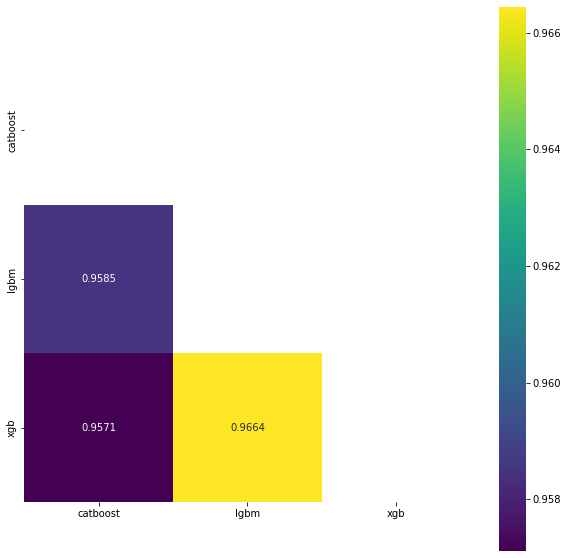

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Выводы: 

больше всего корреляция между lightgbm и xgboost  моделями =0.9664, меньше всего между catboost и xgboost=0.9571, а также между catboost и lightgbm моделями=0.9585

Посчитать метрику (roc-auc) на тесте нельзя, т.к. данные о целевом показателе неизвестны-они скрыты организаторами соревнований.

**Задание 2:**

**Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.**

In [105]:
from scipy.stats import gmean, rankdata

прогнозы с помощью арифмитического среднего

In [102]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7838


прогнозы с помощью геометрического среднего 

In [106]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7805


рогнозы с помощью усреднения рангов

In [107]:
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7794


In [108]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.777


Выводы: 

OOF-score для catboost = 0.7687, OOF-score для lightgbm = 0.8098, OOF-score для xgboost=0.7553.

Комбинация с усреднением и рангами дает модель, которая лучше catboost и xgboost, но хуже гораздо чем лучшая модель - lightgbm.

**Задание 3: Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.**

Сделано в п.1

**Задание 4: Выполнить задание 2 для трех моделей.**

Сделано в п.2

**Задание 5: (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.**

In [122]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [124]:
logistic_regression = LogisticRegression(random_state=27)

pipeline_std = Pipeline(
    steps=[("scaling", StandardScaler()), ("estimator", logistic_regression)]
)
pipeline_mm = Pipeline(
    steps=[("scaling", MinMaxScaler()), ("estimator", logistic_regression)]
)

In [130]:
scores

,catboost,lgbm,xgb
0,0.026742,0.029208,0.036814
1,0.083633,0.084001,0.083318
2,0.035981,0.056367,0.046375
3,0.292460,0.241633,0.207585
4,0.083633,0.084001,0.083318
...,...,...,...
110088,0.083633,0.084001,0.083318
110089,0.051170,0.051929,0.057691
110090,0.083633,0.084001,0.083318
110091,0.040527,0.034659,0.035087


In [131]:
cv_std = cross_val_score(
    estimator=pipeline_std,
    X=scores.fillna(0),
    y=target,
    scoring="roc_auc",
    cv=5,
)

print(f"CV-result: {round(np.mean(cv_std), 4)} +/- {round(np.std(cv_std), 3)}")

cv_mm = cross_val_score(
    estimator=pipeline_mm,
    X=scores.fillna(0),
    y=target,
    scoring="roc_auc",
    cv=5,
)

print(f"CV-result: {round(np.mean(cv_mm), 4)} +/- {round(np.std(cv_mm), 3)}")

CV-result: 0.8466 +/- 0.004
CV-result: 0.8468 +/- 0.002


Выводы: качество модели значительно улучшились, т.к. теперь показатель метрики ro-auc=0.8468, что значительно лучше чем у комбинации моделей, так и чем у самой лучшей модели lightgbm = 0.8098

**Задание 6: (опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.**

In [160]:
rnd_clf = RandomForestClassifier(n_estimators=7000, max_depth=6, random_state=42, n_jobs=8,verbose=0)


In [161]:
forest_cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [162]:
estimators, oof_score, oof_preds = random_forest_cross_validation(
    train, target, forest_cv, metric=roc_auc_score, random_classifier=rnd_clf, categorical=categorical
)

Sat Oct 30 20:25:40 2021, Cross-Validation, 110093 rows, 68 cols
Fold 1, Valid score = 0.71924
Fold 2, Valid score = 0.70181
Fold 3, Valid score = 0.70874
Fold 4, Valid score = 0.70873
Fold 5, Valid score = 0.69577
OOF-score = 0.7249


In [163]:
oof_preds_rnd_clf=oof_preds.copy()

In [164]:
oof_preds_rnd_clf

array([0.02544242, 0.08216327, 0.05083473, ..., 0.08216327, 0.04018545,
       0.07390178])

Результат для случайного леса - OOF-score = 0.7249 самый худший

In [165]:
scores = pd.DataFrame({
    "catboost": oof_preds_cb,
    "lgbm": oof_preds_lgb,  
    "xgb": oof_preds_xgb,
    "rnd_clf":oof_preds_rnd_clf
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

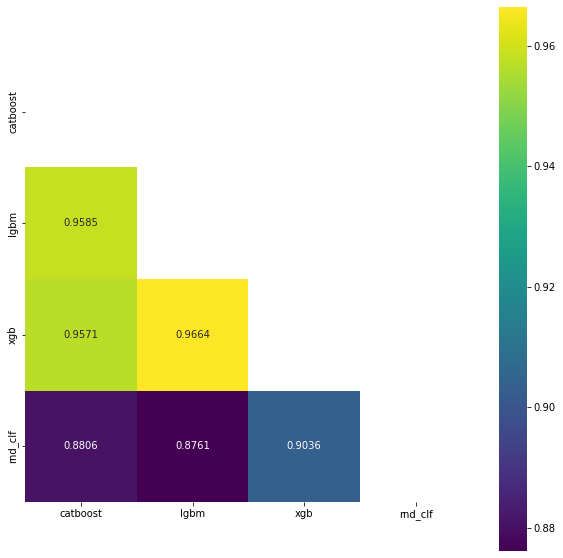

In [166]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

Меньше всего корреляции между lightgbm и rnd_clf (случайным лесом) и между catboost и rnd_clf (случайным лесом)

Для примера можно посчитать как повлияла модель случайного леса на результат комбинации моделей на примере среднего арифметического

In [167]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(target, scores_mean)
print(f"Score = {round(score, 4)}")

Score = 0.7747


Модель случайного леса уменьшила метрику комбинации по среднему арифметическому по сравнению с 3 моделями 

Score(4 модели) = 0.7747 - меньше чем результат комбинации из 3 моделей Score(3 модели) = 0.7838

In [168]:
logistic_regression = LogisticRegression(random_state=27)

pipeline_std = Pipeline(
    steps=[("scaling", StandardScaler()), ("estimator", logistic_regression)]
)
pipeline_mm = Pipeline(
    steps=[("scaling", MinMaxScaler()), ("estimator", logistic_regression)]
)

In [169]:
scores

,catboost,lgbm,xgb,rnd_clf
0,0.026742,0.029208,0.036814,0.025442
1,0.083633,0.084001,0.083318,0.082163
2,0.035981,0.056367,0.046375,0.050835
3,0.292460,0.241633,0.207585,0.188228
4,0.083633,0.084001,0.083318,0.082163
...,...,...,...,...
110088,0.083633,0.084001,0.083318,0.082163
110089,0.051170,0.051929,0.057691,0.057449
110090,0.083633,0.084001,0.083318,0.082163
110091,0.040527,0.034659,0.035087,0.040185


In [170]:
cv_std = cross_val_score(
    estimator=pipeline_std,
    X=scores.fillna(0),
    y=target,
    scoring="roc_auc",
    cv=5,
)

print(f"CV-result: {round(np.mean(cv_std), 4)} +/- {round(np.std(cv_std), 3)}")

cv_mm = cross_val_score(
    estimator=pipeline_mm,
    X=scores.fillna(0),
    y=target,
    scoring="roc_auc",
    cv=5,
)

print(f"CV-result: {round(np.mean(cv_mm), 4)} +/- {round(np.std(cv_mm), 3)}")

CV-result: 0.8476 +/- 0.004
CV-result: 0.8482 +/- 0.003


Вывод: модель слегка улучшилась по сравнению с предыдущим разом 

    - 4 модели в комбинации:
CV-result: 0.8476 +/- 0.004
CV-result: 0.8482 +/- 0.003

    - 3 модели в комбинации:
CV-result: 0.8466 +/- 0.004
CV-result: 0.8468 +/- 0.002